In [1]:
from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import random
from shapely.geometry import shape, Point, LineString, Polygon
import geopandas as gpd

In [2]:
# image_path = "./multiple_roads/3/2020-03-18_2020-04-27/image.tif"
# shape_path = "./train/pac_2024_training.shp"

In [3]:
image_path = "./datasets/dataset_part_0/128_2016-12-29_2017-02-07/128_128_2016-12-29_2017-02-07.tif"
shape_path = "./datasets/dataset_part_0/128_2016-12-29_2017-02-07/128_2016-12-29_2017-02-07.shp"

In [4]:
def convert_to_relative(image_path, shape_path):
    # Read the shapefile once
    gdf = gpd.read_file(shape_path)
    geometry = gdf['geometry']

    with rasterio.open(image_path) as src:
        bounds = src.bounds
        width, height = src.width, src.height
        x_min, y_max = bounds.left, bounds.top
        x_max, y_min = bounds.right, bounds.bottom

    bbox_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)])

    filtered_geometry = geometry[geometry.apply(lambda x: x.intersects(bbox_polygon))]
    filtered_geometry = filtered_geometry.apply(lambda x: x.intersection(bbox_polygon))

    relative_geometry = []

    def to_relative_coords(geom):
        x, y = geom.xy
        x_img = (np.array(x) - x_min) / (x_max - x_min) * width
        y_img = (y_max - np.array(y)) / (y_max - y_min) * height
        return (x_img, y_img)

    for geom in filtered_geometry:
        relative_geometry.append(to_relative_coords(geom))

    return relative_geometry

In [5]:
points = convert_to_relative(image_path, shape_path)

In [6]:
print(points)

[(array([222.01978444, 212.99381039]), array([185.97065009, 249.99193508]))]


[222.01978444 212.99381039] [185.97065009 249.99193508]


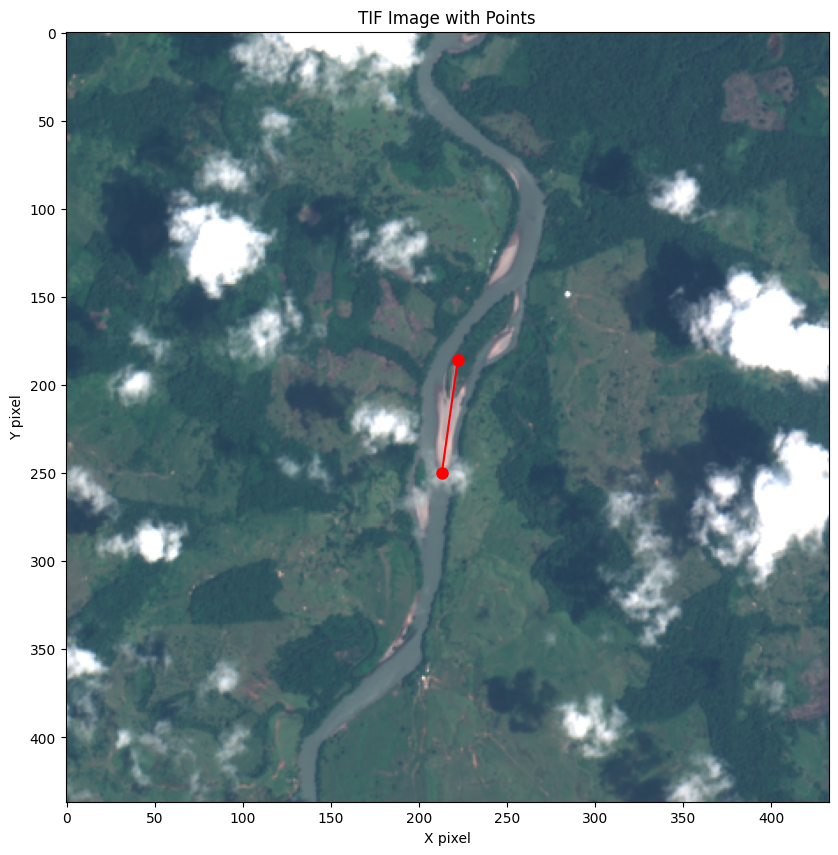

In [7]:
with rasterio.open(image_path) as src:
    image_data = src.read()
    image_data = np.transpose(image_data, (1, 2, 0))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_data, cmap=None)

# Plot the points on the image
for point in points:
    x, y = point
    print(x, y)
    ax.plot(x, y, marker='o', color='red', markersize=8)  # Plotting points as red circles

# Set axis labels
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')
ax.set_title('TIF Image with Points')

# Display the plot
plt.show()

In [8]:
import random

def random_crop_with_object(image, line, crop_size):
    img_height, img_width = image.shape[:2]
    crop_height, crop_width = crop_size

    (array1 , array2) = line[0]
    x1, y1 = array1
    x2, y2 = array2

    x_min = min(x1, x2)
    y_min = min(y1, y2)
    x_max = max(x1, x2)
    y_max = max(y1, y2)

    x_min_valid = max(0, int(x_max - crop_width))
    x_max_valid = min(int(img_width - crop_width), int(x_min))
    y_min_valid = max(0, int(y_max - crop_height))
    y_max_valid = min(int(img_height - crop_height), int(y_min))

    if x_max_valid <= x_min_valid or y_max_valid <= y_min_valid:
        raise ValueError("Crop size is too large to contain the object.")

    crop_x = random.randint(x_min_valid, x_max_valid)
    crop_y = random.randint(y_min_valid, y_max_valid)

    cropped_image = image[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]

    new_x1 = x1 - crop_x
    new_y1 = y1 - crop_y
    new_x2 = x2 - crop_x
    new_y2 = y2 - crop_y

    new_line = (np.array([new_x1, new_y1]), np.array([new_x2, new_y2]))

    return cropped_image, new_line

In [16]:
image, updated_points = random_crop_with_object(image_data, points, (128, 128))
print(updated_points)

(array([99.01978444, 38.99381039]), array([62.97065009, 75.99193508]))


99.01978443983631 38.99381039417497
62.97065008673573 75.99193508426725


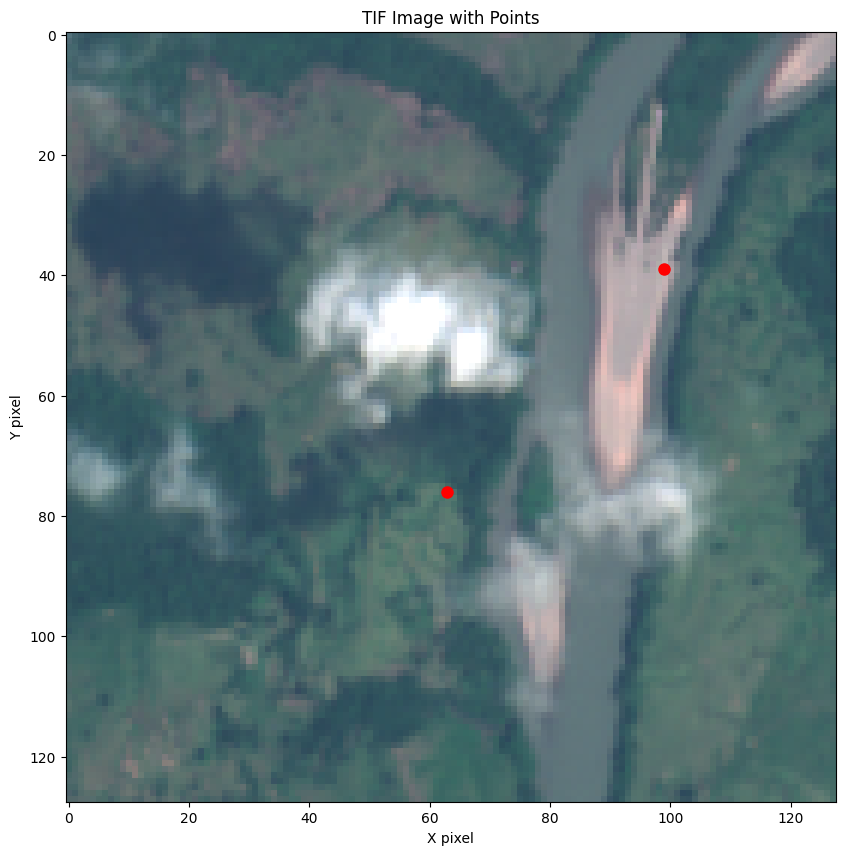

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap=None)
# Plot the points on the image
for point in updated_points:
    x, y = point
    print(x, y)
    ax.plot(x, y, marker='o', color='red', markersize=8)  # Plotting points as red circles

# Set axis labels
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')
ax.set_title('TIF Image with Points')

# Display the plot
plt.show()